# Modeling trace element behavior in plagioclase
**Jordan Lubbers**

*Oregon State University <br>
College of Earth, Ocean, and Atmopheric Sciences*<br>

## Motivation
Plagioclase trace element partitioning displays an Arrhenius relationship (e.g., Blundy and Wood, 1991; Bindeman et al., 1998, Tepley et al., 2010, Nielsen et al., 2017). 

Here we utilize the ```magmatrace``` function ```plag_kd_calc``` to calculate partition coefficients and their uncertainties for a given plagioclase anorthite composition: 

```
plag_kd_calc(element, An, temp, method)
    calculates the partition coefficient for a given element in plagioclase based on its anorthite
    content according to the Arrhenius relationship as originally defined by Blundy and Wood (1991)
    
    This function gives the user an option of three experimental papers to choose from when calculating 
    partition coefficient:
    
    Bindeman et al., 1998 = ['Li','Be','B','F','Na','Mg','Al','Si','P','Cl','K','Ca','Sc',
    'Ti','Cr','Fe','Co','Rb','Sr','Zr','Ba','Y','La','Ce','Pr','Nd','Sm','Eu','Pb']
    
    Nielsen et al., 2017 = ['Mg','Ti','Sr','Y','Zr','Ba','La','Ce','Pr','Nd','Pb']
    
    Tepley et al., 2010 = ['Sr','Rb','Ba','Pb','La','Nd','Sm','Zr','Th','Ti']
    
    
    Inputs:
    -------
    element : string
    The element you are trying to calculate the partition coefficient for. See Bindeman 1998 for supported
    elements
    
    An : array-like
    Anorthite content (between 0 and 1) of the plagioclase. This can be a scalar value or Numpy array
    
    temp: scalar
    Temperature in Kelvin to calculate the partition coefficient at 
    
    method : string
    choice of 'Bindeman', 'Nielsen', 'Tepley'. This uses then uses the Arrhenius parameters from 
    Bindeman et al., 1998, Nielsen et al., 2017, or Tepley et al., 2010, respectively.
    
    Returns:
    --------
    kd_mean : array-like
    the mean partition coefficient for the inputs listed
    
    kd_std : array-like
    standard deviation of the partition coefficient calculated via 
    Monte Carlo simulation of 1000 normally distributed random A and B
    parameters based on their mean and uncertainties
```



In [1]:
import magmatrace_current as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

## Calculating plagioclase partition coefficients
Here we'll set up a range of An values and compare the various models (e.g., Bindeman, Nielsen, Tepley) for trace element partitioning in plagioclase. The ```plag_kd_calc``` has a built in warning if the An values of the plagioclase you are working with are too far outside the calibration range for a given model. This is especially important for An < 50 using Tepley et al., (2010).

In [2]:
T = 800 + 273.15  # K
An = np.arange(0.1, 1, 0.05)
elements = ["Sr", "Ba", "La", "Mg"]
methods = ["Bindeman", "Nielsen", "Tepley"]

kd_nielsen = pd.DataFrame()
kd_bindeman = pd.DataFrame()
kd_tepley = pd.DataFrame()

for method in methods:

    for element in elements:
        
        if element == 'Mg' and method == 'Tepley':
            continue

        kds = mt.plag_kd_calc(element, An, T, method)

        df = pd.DataFrame(
            dict([
                    ("kd", kds[0]),
                    ("uncertainty", kds[1]),
                    ("element", element),
                    ("An", An),
                ]))

        if "Nielsen" in method:

            kd_nielsen = pd.concat([kd_nielsen, df])

        elif "Bindeman" in method:

            kd_bindeman = pd.concat([kd_bindeman, df])

        elif "Tepley" in method:

            kd_tepley = pd.concat([kd_tepley, df])

/Users/jordanlubbers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Over half your An values are significantly below the calibration range in Tepley et al., (2010)and most likely will produce partition coefficient values that are significantly overestimated


We have now created a dataframe for each model that looks like the following:

In [3]:
kd_bindeman.head(10)

,kd,uncertainty,element,An
0,17.392342,1.349923,Sr,0.10
1,14.673626,1.154226,Sr,0.15
2,12.380391,0.992821,Sr,0.20
3,10.445972,0.858542,Sr,0.25
4,8.814159,0.745815,Sr,0.30
5,7.437560,0.650328,Sr,0.35
6,6.276213,0.568759,Sr,0.40
7,5.296420,0.498548,Sr,0.45
8,4.469766,0.437716,Sr,0.50
9,3.772287,0.384724,Sr,0.55


## Visualize results of each model
We can see here that the Bindeman and Nielsen results are fairly similar, especially for intermediate An values, however as the Tepley model was mainly calibrated on high An plagioclase extrapolating the results to lower An concentrations results in unrealistically high partition coefficients. 

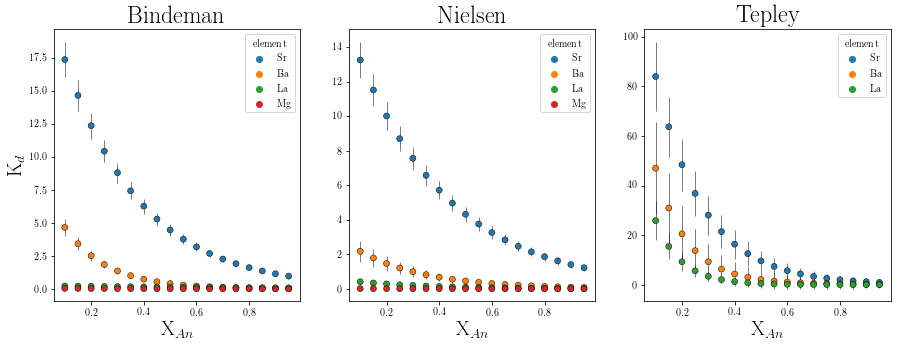

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

axes = ax.ravel()

for a, name, method in zip(axes, methods, [kd_bindeman, kd_nielsen, kd_tepley]):

    a.errorbar(
        data=method,
        x="An",
        y="kd",
        yerr="uncertainty",
        marker=None,
        ls="",
        ecolor="k",
        elinewidth=0.5,
        zorder=0,
        label="",
    )

    sns.scatterplot(data=method, x="An", y="kd", hue="element", ec="k", ax=a)
    a.set_title("{}".format(name), fontsize=24)
    a.set_xlabel("X$_{An}$", fontsize=20)

    if name == "Bindeman":

        a.set_ylabel("K$_d$", fontsize=20)

    else:

        a.set_ylabel("")

## Plagioclase equilibrium liquid compositions
More realistically, we will have some plagioclase measurements whereby we can calculate their An concentrations. Because we have the concentration of the solid and the value for the partition coefficient, we can solve for the concentration of the liquid in equilibrium with the plagioclase at the time of its crystallization.

$$ C_l = \frac{C_s}{K_d} $$

This assumes a temperature and will be dependent on the system under investigation

For this example we will be looking at plagioclase from the 74ka Youngest Toba Tuff from Indonesia. Chesner (1998) reports crystallization temperatures of 700-760 degrees C.

In [5]:
plag_data = pd.read_excel('/Users/jordanlubbers/Desktop/PhD/Research/DATA/Toba/spreadsheets/plag_proc_all.xlsx')
glass_data = pd.read_excel('/Users/jordanlubbers/Desktop/PhD/Research/DATA/Toba/spreadsheets/Toba_glass_proc_all.xlsx')

Text(0.5, 1.0, 'Plagioclase concentrations')

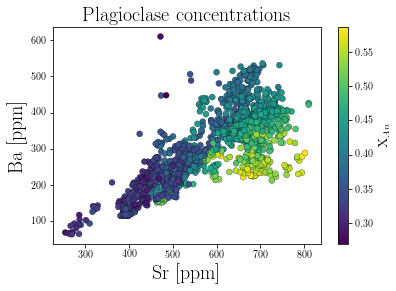

In [6]:
fig,ax = plt.subplots()

s = ax.scatter(plag_data['Sr'],plag_data['Ba'],c = plag_data['An'],ec = 'k',lw = .25)
cbar = fig.colorbar(s, ax = ax)
cbar.set_label(label = 'X$_{An}$',fontsize = 14)
ax.set_xlabel('Sr [ppm]',fontsize = 20)
ax.set_ylabel('Ba [ppm]',fontsize = 20)
ax.set_title('Plagioclase concentrations',fontsize = 20)

### Calculate equilibrium liquid concentrations

In [8]:
element = "Ba"
element2 = "Sr"
T = 700 + 273.15  # K
method = "Bindeman"


an = np.array(plag_data["An"].to_numpy(), np.newaxis)

# calculate partition coefficient for element 1
kd, kd_std = mt.plag_kd_calc(element, an, T, method)

# calculate partition coefficient for element 2
kd2, kd2_std = mt.plag_kd_calc(element2, an, T, method)


# equilibrium liquid compositions based on partition
# coefficients above
cl = plag_data[element] / kd
cl2 = plag_data[element2] / kd2

# propagation of errors following division of two things with uncertainties
# in this dataset the columns for uncertainty are denoted with _se at the end
# e.g. for Ba it would be Ba_se
cl_unc = cl * np.sqrt(
    (kd_std / kd) ** 2 + (plag_data["{}_se".format(element)] / plag_data[element]) ** 2
)
cl2_unc = cl2 * np.sqrt(
    (kd2_std / kd2) ** 2 + (plag_data["{}_se".format(element2)] / plag_data[element2]) ** 2
)

### Visualize equilibrium liquids
We will also compare these compositions to the erupted pumice glass composition

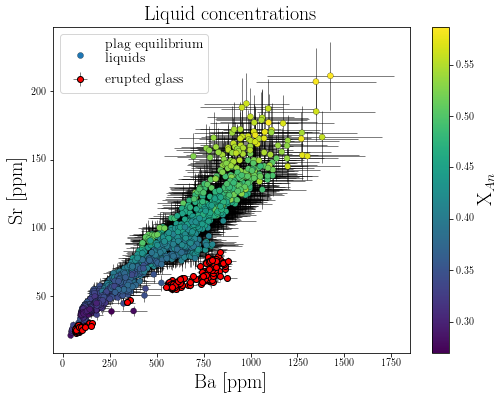

In [10]:
fig, ax = plt.subplots(figsize = (8,6))
ax.errorbar(
    cl,
    cl2,
    xerr=cl_unc,
    yerr=cl2_unc,
    marker=None,
    ls="",
    ecolor="k",
    elinewidth=0.5,
    zorder=0,
)
s = ax.scatter(cl, cl2, c=an, ec="k", lw=0.25, label="plag equilibrium \n liquids")
cbar = fig.colorbar(s, ax=ax)
cbar.set_label(label="X$_{An}$", fontsize=20)

ax.errorbar(
    glass_data[element],
    glass_data[element2],
    xerr=glass_data["{}_se".format(element)],
    yerr=glass_data["{}_se".format(element2)],
    marker='o',
    mfc = 'red',
    mec = 'k',
    ls="",
    ecolor="k",
    elinewidth=0.5,
    label = 'erupted glass'
)

ax.set_xlabel("{} [ppm]".format(element), fontsize=20)
ax.set_ylabel("{} [ppm]".format(element2), fontsize=20)
ax.set_title("Liquid concentrations", fontsize=20)

ax.legend(loc = 'upper left',fontsize = 14)